In [346]:
import numpy as np
import pandas as pd
import random


#Sklearn functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, plot_roc_curve
import xgboost as xgb

from imblearn.over_sampling import SVMSMOTE
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt


Actions:
1. Read Metaphlan table and Metadata.
2. Filter out based on prevalence and taxonomic level
3. Split data (folds)
4. Test prediction model


Some other interesting approaches:
1. Try Over/Under- sampling using SMOTE https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/


In [42]:
def Creat_taxa_table(df):
    new_columns = []
    new_names = []
    non_zero_proportions = []
    Levels = []
    for column in df.columns:
        # Extract the name after the last '.' in the column header
        last_dot_index = column.rfind('.')
        new_column_name = column[last_dot_index + 1:]
        new_columns.append(column)
        new_names.append(new_column_name)

        # Calculate the proportion of non-zero values in the column
        non_zero_count = df[column].astype(bool).sum()
        total_count = df[column].count()
        non_zero_proportion = non_zero_count / total_count
        non_zero_proportions.append(non_zero_proportion)

        #Get info about taxonomy level
        level = new_column_name.split("__")[0]
        Levels.append(level)
    new_df = pd.DataFrame({
        'Taxonomy': new_columns,
        'Short_taxonomy': new_names,
        'Prevalence': non_zero_proportions,
        'Taxonomy_level' : Levels
    })

    return new_df
    
def Shorten_names(df, Info):
    short_names = Info['Short_taxonomy'].tolist()
    new_column_names = dict(zip(df.drop(columns=["NEXT_ID"]).columns, short_names))
    new_column_names["NEXT_ID"] = "NEXT_ID"
    df = df.rename(columns=new_column_names)
    return(df)

In [44]:
DF = pd.read_csv("Data/Taxonomy_for_prediction.tsv", delimiter="\t")
Meta = pd.read_csv("Data/Metadata_for_analysis_cross.tsv", delimiter="\t")

#Remove unclassified.
DF = DF.drop(columns=['UNCLASSIFIED'])
#Get table with: 1. Taxa, 2. Short name, 3. Prevalence
Info_taxonomy = Creat_taxa_table(DF.drop(columns=["NEXT_ID"]) )
#Use short names
DF = Shorten_names(DF, Info_taxonomy)

We will create a function that accepts:
1.  Metaphlan taxonomy | taxonomic level | Prevalence threshold  and filters to have the prediciton table
2.  A Phenotype to predict
3. Fold strategy

In [197]:
def Prepare_features_X(df, Level="all", Prev_threshold=0, info = Info_taxonomy, Transform="clr"):
    #filter prevalence
    info = info[info["Prevalence"] >= Prev_threshold]
    if Level != "all":
        info = info[info["Taxonomy_level"] == Level]
        
    ID = df["NEXT_ID"]
    df = df.drop(columns=["NEXT_ID"])    
        
    if Transform == "clr":
        #CLR transform the data    
        df = CLR_transform(df)
    elif Transform == "arcsin":
        df = df.apply(ast_transform, axis=1)
    #Filter
    df_filter = df[ info["Short_taxonomy"] ]
    df_filter.insert(0, "NEXT_ID", ID)
    return(df_filter)
def CLR_transform(df, denominators = None,epsilon=1e-6):
    #ID = df["NEXT_ID"]
    #df = df.drop(columns=["NEXT_ID"])
    #Add a small constant value to avoid division by zero
    df = df + epsilon
    
    if not denominators: 
        # Compute the geometric mean of each row
        geometric_means = np.exp(np.log(df).mean(axis=1))
    else: geometric_means = denominators
    # Divide each row by its geometric mean
    clr_df = df.div(geometric_means, axis=0)

    # Take the natural logarithm of the CLR transformed values
    clr_df = np.log(clr_df)

    #clr_df.insert(0, "NEXT_ID", ID)
    return(clr_df)
def ast_transform(x):
    x = x/x.sum()
    return(np.arcsin(np.sqrt(x))**2)
def Match_x_y(df, metadata, feature_name="infant_health_food_allergy"):
    print(metadata)
    metadata = metadata[["NEXT_ID", feature_name] ]
    merged_df = df.merge(metadata, on="NEXT_ID", how="left")
    print(merged_df)
    merged_df = merged_df.dropna()
    return(merged_df)
    
    

In [357]:
def Run_basic_model(X,y, N_repeats_cv = 1, random_state=7644, CV=10, Model="rf", Oversampling=False):
    np.random.seed(random_state)
    random.seed(random_state)
    steps = []
    
    #print("Running: " + y)
    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
    value_counts_df = Y.value_counts()

    if Oversampling == True:
        oversample = SVMSMOTE()
        steps.append(("over", oversample))        
    
    # Create the Random Forest classifier
    if Model == "rf":
        classifier = RandomForestClassifier(n_estimators=500, random_state=random_state) #100 trees
    elif Model == "xgb":
        if Oversampling == False:
            W = sum(Y)/len(Y)
        else: W = 1
        classifier = xgb.XGBClassifier(random_state=random_state, scale_pos_weight=W)
        #classifier = xgb.XGBClassifier( colsample_bylevel=0.075, max_depth=6, learning_rate=0.0025, n_estimators=4000,subsample=0.6, min_child_weight=20. )
    elif Model == "Lasso":
        alpha_values = [0.005,0.01, 0.1, 1.0]  # You can adjust these values based on your data
        param_grid = {'C': alpha_values}
        lasso = LogisticRegression(penalty='l1',solver='liblinear', random_state=random_state)
        grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='roc_auc')
        grid_search.fit(X, Y)
        classifier = grid_search.best_estimator_
        print("Best Alpha:", grid_search.best_params_['C'])

        
    steps.append(('classifier', classifier))
    pipeline = Pipeline( steps )

    # Create cross-validation strategy
    cv = RepeatedStratifiedKFold(n_splits=CV, n_repeats=N_repeats_cv, random_state=random_state)

    # Run the cross-validation and get the accuracy scores
    scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='roc_auc' )

    # Print the average accuracy and standard deviation
    print("Average AUC:", scores.mean())
    print("Standard Deviation:", scores.std())

def Check_Permanova(Input_ml, Phenotype):
    from skbio.stats.distance import permanova
    from skbio.diversity import beta_diversity

    Distance = beta_diversity(metric = 'sqeuclidean', counts = Input_ml.drop(columns = [Phenotype, "NEXT_ID"]  ) , ids= Input_ml.index)
    Result = permanova(Distance, Input_ml, column=Phenotype, permutations=999)
    P = Result["p-value"]
    print("Permanova of {P} has a P-value (999 perm) of {R}".format(P=Phenotype, R=str(P)) )

In [316]:
DF2 = Prepare_features_X(DF, Level="all", Prev_threshold=0.2, Transform="clr" )

In [359]:
phenotype_mapping = {'yes': 1, 'no': 0}
#Test naive classifiers (without much hyperparameter optimization, for that, check below)
for Phenotype in ["infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed", "infant_health_eczema_diagnosis_strict", "infant_health_breathing_difficulties" ]:
    print("===={P}=====".format(P=Phenotype))
    Input_ml = Match_x_y(DF2, Meta, Phenotype)
    Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
    print(Input_ml[Phenotype].value_counts())
    print("===Lasso===")
    Run_basic_model(Input_ml, Phenotype, CV=5, Oversampling=False, Model="Lasso")
    print("===XGboost===")
    Run_basic_model(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=True )
    print("===Permanova===")
    Check_Permanova(Input_ml, Phenotype)

====infant_health_food_allergy=====
0    347
1     40
Name: infant_health_food_allergy, dtype: int64
===Lasso===
Best Alpha: 0.1
Average AUC: 0.5068737060041407
Standard Deviation: 0.15455318972104365
===XGboost===
Average AUC: 0.5297463768115941
Standard Deviation: 0.07698859375995432
===Permanova===
Permanova of infant_health_food_allergy has a P-value (999 perm) of 0.947
====infant_health_eczema_diagnosis_relaxed=====
0    278
1     89
Name: infant_health_eczema_diagnosis_relaxed, dtype: int64
===Lasso===
Best Alpha: 0.01
Average AUC: 0.5578584160937102
Standard Deviation: 0.08424491705679267
===XGboost===
Average AUC: 0.4644005177828707
Standard Deviation: 0.03405174328249634
===Permanova===
Permanova of infant_health_eczema_diagnosis_relaxed has a P-value (999 perm) of 0.037
====infant_health_eczema_diagnosis_strict=====
1    89
0    50
Name: infant_health_eczema_diagnosis_strict, dtype: int64
===Lasso===
Best Alpha: 0.01
Average AUC: 0.6302614379084968
Standard Deviation: 0.06009

In [162]:
def HyperSelect_XGB(X = Input_ml , y = "infant_health_breathing_difficulties", N_repeats_cv = 1, CV=5, random_state=7644, Oversampling=False
):
    steps = []
    #Get Y and X
    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
    value_counts_df = Y.value_counts()
    #include oversampling strategy
    if Oversampling:
        oversample = SVMSMOTE()
        steps.append(("over", oversample))
    if not Oversampling:
        W = sum(Y) / len(Y)
    else: W = 1
    classifier = xgb.XGBClassifier(random_state=random_state, scale_pos_weight=W)

    steps.append(('classifier', classifier))
    pipeline = Pipeline(steps)


    # Define the hyperparameter grid for XGBoost
    param_grid = {
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }

    # Create cross-validation strategy
    cv = RepeatedStratifiedKFold(n_splits=CV, n_repeats=N_repeats_cv, random_state=random_state)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X, Y)

    # Print the best hyperparameters and corresponding performance
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best AUC Score:", grid_search.best_score_)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Print the average AUC and standard deviation from cross-validation using the best model
    scores = cross_val_score(best_model, X, Y, cv=cv, scoring='roc_auc')
    print("Average AUC with Best Model:", scores.mean())
    print("Standard Deviation:", scores.std())

(466, 54)

Non-function version of fit, to play around

/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


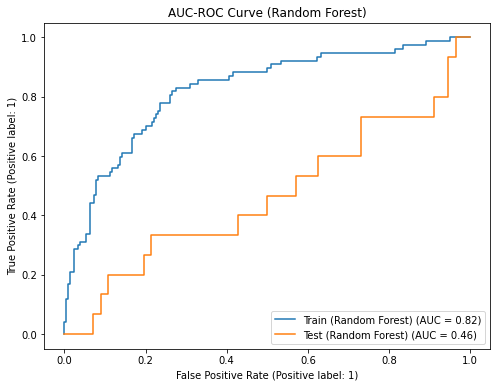

In [348]:
Phenotype = "infant_health_eczema_diagnosis_relaxed"
Input_ml = Match_x_y(DF2, Meta, Phenotype)
Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
#HyperSelect_XGB(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=True )


Y = Input_ml[Phenotype]
X = Input_ml.drop(columns=[Phenotype, "NEXT_ID"])

model = xgb.XGBClassifier( colsample_bylevel=0.075, max_depth=6, learning_rate=0.0025, n_estimators=4000,subsample=0.6, min_child_weight=20. )
#model = xgb.XGBClassifier(random_state=random_state)
model = LogisticRegression(penalty='l1', C = 0.1,solver='liblinear', random_state=random_state)


steps = []
steps.append(('classifier', model))
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

# Fit the model on the training data
model.fit(X_train, y_train)

# Plot the AUC-ROC curve for both training and testing sets
plt.figure(figsize=(8, 6))
plot_roc_curve(model, X_train, y_train, ax=plt.gca(), name="Train (Random Forest)")
plot_roc_curve(model, X_test, y_test, ax=plt.gca(), name="Test (Random Forest)")
plt.title("AUC-ROC Curve (Random Forest)")
plt.show()

Trying a genetic algorithm for hyperparameter selction. This is very time consuming. It is a deep search in the hyperparemeter space (inspired by biological rules of evolution).


In [387]:
def HyperSelect_genetic(X, y, Model="rf", random_stat=876, CV=3 ):
    from sklearn_genetic import GASearchCV
    from sklearn_genetic import ExponentialAdapter
    from sklearn_genetic.space import Continuous, Categorical, Integer

    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
     
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    
    mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
    crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)

    if Model == "rf":
        param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30),
              'max_leaf_nodes': Integer(2, 35),
              'n_estimators': Integer(100, 300)}
        Model = RandomForestClassifier()
    elif Model == "xgb":
        param_grid = { 'max_depth': Integer(3, 10),
        'learning_rate': Continuous(0.01, 0.3,distribution='log-uniform' ),
        'n_estimators': Integer(100, 500),
    'subsample': Continuous(0.8, 1.0, distribution='log-uniform') ,
    'colsample_bylevel': Continuous(0.8, 1.0, distribution='log-uniform') ,
        }
        Model =  xgb.XGBClassifier(random_state=random_state)
        
    cv = StratifiedKFold(n_splits=CV, shuffle=False)
    evolved_estimator = GASearchCV(
            estimator = Model,
            cv=cv,
            verbose=1,
            scoring="roc_auc",
            population_size=20,
            generations=25,
            mutation_probability=mutation_adapter,
            crossover_probability=crossover_adapter,
            param_grid=param_grid,
            n_jobs=1,
        )

    evolved_estimator.fit(X_train, y_train) 
    print(evolved_estimator.best_params_)

    plt.figure(figsize=(8, 6))
    plot_roc_curve(evolved_estimator, X_train, y_train, ax=plt.gca(), name="Train (Random Forest)")
    plot_roc_curve(evolved_estimator, X_test, y_test, ax=plt.gca(), name="Test (Random Forest)")
    plt.title("AUC-ROC Curve (Random Forest)")
    plt.show()
    
    y_pred_proba = evolved_estimator.predict_proba(X_test)[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print("AUC Score:", auc_score)

====infant_health_breathing_difficulties=====
0    260
1     92
Name: infant_health_breathing_difficulties, dtype: int64
===XGboost===


/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.470096	0.0097395  	0.486641   	0.45015    
1  	40    	0.477974	0.00677295 	0.490625   	0.463199   
2  	40    	0.482303	0.00890235 	0.502434   	0.464782   
3  	40    	0.487987	0.00873324 	0.50283    	0.476557   
4  	40    	0.492837	0.00837464 	0.502983   	0.480836   
5  	40    	0.499549	0.00578304 	0.504502   	0.484809   
6  	40    	0.50323 	0.00615039 	0.514324   	0.487884   
7  	40    	0.503085	0.0117522  	0.519035   	0.460401   
8  	40    	0.510207	0.00618674 	0.519035   	0.502983   
9  	40    	0.511971	0.00647927 	0.519035   	0.501471   
10 	40    	0.516125	0.00503969 	0.520427   	0.502218   
11 	40    	0.519363	0.00153911 	0.521888   	0.514324   
12 	40    	0.520503	0.00149671 	0.525991   	0.519035   
13 	40    	0.520924	0.00127307 	0.525991   	0.520427   
14 	40    	0.52252 	0.00258188 	0.525991   	0.520427   
15 	40    	0.52419 	0.00248564 	0.525991   	0.520427   
16 	40    	0.525323	0.00167164 	0.526408   	0.52

/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


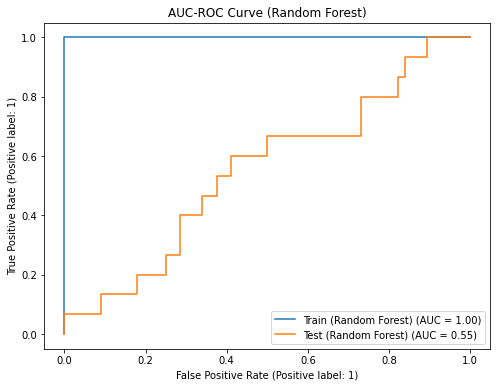

AUC Score: 0.5511904761904762


In [388]:
phenotype_mapping = {'yes': 1, 'no': 0}
#Test a naive classifier
Phenos = ["infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed", "infant_health_eczema_diagnosis_strict", "infant_health_breathing_difficulties" ]
Phenos = ["infant_health_breathing_difficulties"]
for Phenotype in Phenos :
    print("===={P}=====".format(P=Phenotype))
    Input_ml = Match_x_y(DF2, Meta, Phenotype)
    Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
    print(Input_ml[Phenotype].value_counts())
    print("===XGboost===")
    HyperSelect_genetic(Input_ml, Phenotype, CV=5, Model="xgb" )
    #print("===RF===")
    #Run_basic_model(Input_ml, Phenotype, CV=5, Model="rf", Oversampling=True )


Checking that matching is fine. It seems so, so this should not be an issue

In [403]:
DF3 = DF2.sort_values(by="NEXT_ID")
Meta2 = Meta.sort_values(by="NEXT_ID")
print(Meta2[Meta2['NEXT_ID'].isin(DF3['NEXT_ID'])])

merged_df = DF3.merge(Meta, on="NEXT_ID", how="left")
merged_df[ ["NEXT_ID","infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed","infant_health_breathing_difficulties" ]]

      FAMILY       NEXT_ID infant_health_food_allergy  \
235  FAM0329  LLNEXT001964                         no   
151  FAM0234  LLNEXT002107                         no   
317  FAM0430  LLNEXT002486                        yes   
303  FAM0414  LLNEXT002611                         no   
285  FAM0391  LLNEXT002945                         no   
..       ...           ...                        ...   
602  FAM1364  LLNEXT306289                         no   
605  FAM1378  LLNEXT306836                         no   
609  FAM1400  LLNEXT306927                         no   
621  FAM1479  LLNEXT308778                         no   
320  FAM0435  LLNEXT555599                         no   

    infant_health_eczema_diagnosis_relaxed  \
235                                     no   
151                                    yes   
317                                     no   
303                                     no   
285                                    yes   
..                                     

,NEXT_ID,infant_health_food_allergy,infant_health_eczema_diagnosis_relaxed,infant_health_breathing_difficulties
0,LLNEXT001964,no,no,no
1,LLNEXT002107,no,yes,no
2,LLNEXT002486,yes,no,no
3,LLNEXT002611,no,no,no
4,LLNEXT002945,no,yes,yes
...,...,...,...,...
461,LLNEXT306289,no,no,no
462,LLNEXT306836,no,yes,no
463,LLNEXT306927,no,no,no
464,LLNEXT308778,no,no,yes
